In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatch
from matplotlib.patches import FancyBboxPatch
import matplotlib.animation as animation
import requests
import os
import json
import cv2
import time

os.chdir("nhl/")

import nhl
from nhl.team import Team
from nhl.game import Game

os.chdir("..")

base_url='https://statsapi.web.nhl.com/api/v1'

%matplotlib notebook

In [2]:
playTypes = [p['name'] for p in requests.get(base_url + '/playTypes?expand=Penalty').json()]
playTypes

['Unknown',
 'Faceoff',
 'Hit',
 'Giveaway',
 'Goal',
 'Shot',
 'Missed Shot',
 'Penalty',
 'Stoppage',
 'Sub',
 'Fight',
 'Takeaway',
 'Blocked Shot',
 'Period Start',
 'Period End',
 'Game End',
 'Game Scheduled',
 'Period Ready',
 'Period Official',
 'Shootout Complete',
 'Early Intermission Start',
 'Early Intermission End',
 'Game Official',
 'Official Challenge',
 'Emergency Goaltender']

# Testing Game Shot Data Functionality

In [3]:
start_time = time.time()
# get Toronto's game_ids since 2016, excluding preseason and future games
season = ('2016-09-01', '2020-03-01')
tor_game_ids = nhl.api.getGameIDs(10, season=season, include_pre=False, include_future=False)

# get shot data for every shot on goal/goal auston matthews has had ever
AM_list = []
for g in tor_game_ids:
    # create a Game object for the game with id==g
    game = Game(g)
    # extract the shot/goal information
    shots = game.shotData()
    # filter to just AM's shots/goals
    AM_list.append(shots[shots.player == 'Auston Matthews'].copy())
    
# combine into single pandas dataframe
AM = pd.concat(AM_list)
time.time() - start_time

20.266682624816895

In [4]:
AM

,player,shotType,scored,coords,period,periodTime,goalie,playerTeam
14,Auston Matthews,Wrist Shot,False,"[-64.0, 24.0]",1,08:15,Craig Anderson,TOR
37,Auston Matthews,Wrist Shot,True,"[83.0, 5.0]",2,08:02,Craig Anderson,TOR
40,Auston Matthews,Wrist Shot,False,"[57.0, -22.0]",2,14:45,Craig Anderson,TOR
41,Auston Matthews,Slap Shot,True,"[65.0, -20.0]",2,14:50,Craig Anderson,TOR
42,Auston Matthews,Wrist Shot,False,"[86.0, -9.0]",2,18:05,Craig Anderson,TOR
...,...,...,...,...,...,...,...,...
4,Auston Matthews,Wrist Shot,True,"[-79.0, -24.0]",1,06:25,Thatcher Demko,TOR
9,Auston Matthews,Snap Shot,False,"[-78.0, 13.0]",1,12:26,Thatcher Demko,TOR
10,Auston Matthews,Wrist Shot,False,"[-62.0, 15.0]",1,12:33,Thatcher Demko,TOR
12,Auston Matthews,Slap Shot,False,"[-73.0, 19.0]",1,13:27,Thatcher Demko,TOR


In [5]:
# separate goals and shots
goals = AM[AM.scored == True]
shots = AM[AM.scored == False]

# unpack the goal/shots coordinates into numpy arrays
gcoords = np.array([[*coord] for coord in goals.coords.values])
scoords = np.array([[*coord] for coord in shots.coords.values])

# flip everything on the right side of the ice so it all stacks on the left
gcoords[gcoords[:, 0] > 0] *= -1
scoords[scoords[:, 0] > 0] *= -1

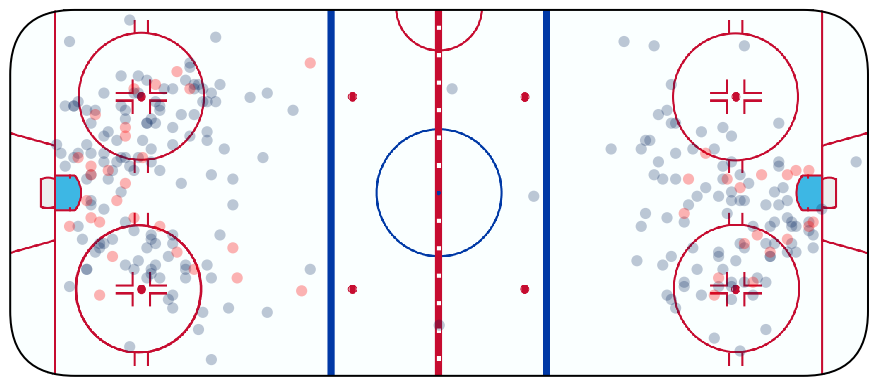

In [6]:
# load icerink image
icerink = cv2.imread('images/icerink.png', cv2.IMREAD_UNCHANGED)
icerink = cv2.cvtColor(icerink, cv2.COLOR_BGRA2RGBA)

# --------------------------------------------------------------- #
# annoying matplotlib stuff to properly plot the rink
plt.rcParams['figure.figsize'] = 12, 8
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0, 0, 1, 1])
ax.set_axis_off()
fig.add_axes(ax)

# for centering the origin at center ice
extent = [-100, 100, -42.5, 42.5]
# drawing black line around the edge
bb = mtransforms.Bbox([[-99.7, -42.675], [99.65, 42.25]])
p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                         abs(bb.width), abs(bb.height),
                         boxstyle="round, pad=0.1, rounding_size=15",
                         fill=False, ec='black', lw=2)
ax.add_patch(p_fancy)
ax.set_xlim(-100.5, 100.5)
ax.set_ylim(-43, 43)
# --------------------------------------------------------------- #

# put the rink on the plot
plt.imshow(icerink, extent=extent)

# plot shot data
plt.scatter(scoords[:, 0], scoords[:, 1], c='#00205B', s=125, alpha=0.25, edgecolor='none')

# plot the goal data
plt.scatter(gcoords[:, 0], gcoords[:, 1], c='red', s=125, alpha=0.3, edgecolor='none')
# plt.scatter(gcoords[:, 0], gcoords[:, 1], c='#00205B', marker='x', s=75, alpha=0.6)

plt.savefig('AM-all-SOG.png', transparent=True, dpi=300)
plt.show()

## Requesting and Extracting Live Data

In [2]:
# get the New York Islander's (team_id 2) previous game information
nyi_game_id = requests.get(base_url + '/teams/2?expand=team.schedule.previous').json()['teams']

# index ALL the way in to get the game_id (gamePk)
game_id = nyi_game_id[0]['previousGameSchedule']['dates'][0]['games'][0]['gamePk']

# request live feed data
nyi_game = requests.get(base_url + f'/game/{game_id}/feed/live').json()

# all the *live* data
live_data = nyi_game['liveData']

# all the *plays* in the live data
play_data = live_data['plays']['allPlays']

## Extract Shot Data

In [3]:
nyi_bos = Game(game_id)
shots = nyi_bos.shotData()
shots

,shooter,result,other,shotType,coords,period,periodTime,shooterTeam,otherTeam
0,Brandon Carlo,shot,Semyon Varlamov,Wrist Shot,"[15.0, 38.0]",1,01:16,BOS,NYI
1,Brandon Carlo,shot,Semyon Varlamov,Wrist Shot,"[-37.0, 32.0]",1,01:23,BOS,NYI
2,Ryan Pulock,shot,Tuukka Rask,Wrist Shot,"[-36.0, -35.0]",1,02:07,NYI,BOS
3,Ryan Pulock,blocked,Charlie Coyle,None,"[76.0, -4.0]",1,02:16,NYI,BOS
4,Jake DeBrusk,shot,Semyon Varlamov,Wrist Shot,"[-47.0, -35.0]",1,02:21,BOS,NYI
...,...,...,...,...,...,...,...,...,...
110,Par Lindholm,shot,Semyon Varlamov,Wrist Shot,"[-81.0, -8.0]",3,18:17,BOS,NYI
111,Nick Leddy,shot,Tuukka Rask,Wrist Shot,"[36.0, 3.0]",3,18:47,NYI,BOS
112,Ryan Pulock,shot,Tuukka Rask,Slap Shot,"[38.0, -13.0]",3,19:14,NYI,BOS
113,Charlie Coyle,missed,None,None,"[-86.0, 11.0]",3,19:21,BOS,NYI


In [13]:
temp = nyi_bos.live_data
temp['plays']['allPlays'][-6]

{'players': [{'player': {'id': 8475745,
    'fullName': 'Charlie Coyle',
    'link': '/api/v1/people/8475745'},
   'playerType': 'Shooter'}],
 'result': {'event': 'Missed Shot',
  'eventCode': 'NYI707',
  'eventTypeId': 'MISSED_SHOT',
  'description': 'Charlie Coyle Goalpost'},
 'about': {'eventIdx': 311,
  'eventId': 707,
  'period': 3,
  'periodType': 'REGULAR',
  'ordinalNum': '3rd',
  'periodTime': '19:21',
  'periodTimeRemaining': '00:39',
  'dateTime': '2020-02-29T21:03:32Z',
  'goals': {'away': 4, 'home': 0}},
 'coordinates': {'x': -86.0, 'y': 11.0},
 'team': {'id': 6,
  'name': 'Boston Bruins',
  'link': '/api/v1/teams/6',
  'triCode': 'BOS'}}

In [15]:
a, b, c = [None]*3

## Load and Display Rink

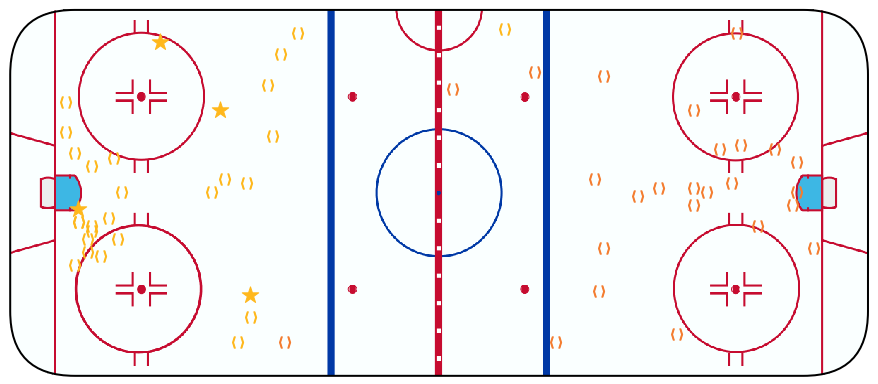

In [407]:
icerink = cv2.imread('images/icerink.png', cv2.IMREAD_UNCHANGED)
icerink = cv2.cvtColor(icerink, cv2.COLOR_BGRA2RGBA)

# annoying matplotlib stuff (I don't even know if this is needed...)
plt.rcParams['figure.figsize'] = 12, 8
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0, 0, 1, 1])
ax.set_axis_off()
fig.add_axes(ax)
# for centering the origin at center ice
extent = [-100, 100, -42.5, 42.5]
bb = mtransforms.Bbox([[-99.7, -42.675], [99.65, 42.25]])
p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                         abs(bb.width), abs(bb.height),
                         boxstyle="round, pad=0.1, rounding_size=15",
                         fill=False,
                         ec='black',
                         lw=2)
ax.add_patch(p_fancy)
ax.set_xlim(-100.5, 100.5)
ax.set_ylim(-43, 43)
# --------------------------------------------------------------- #

# put the rink on the plot
plt.imshow(icerink, extent=extent)

# plot shot data
plt.scatter(bos_shots[:, 0], bos_shots[:, 1], marker=r"$\langle\;\rangle$", c='#FFB81C', s=150)
plt.scatter(nyi_shots[:, 0], nyi_shots[:, 1], marker=r"$\langle\;\rangle$", c='#F47D30', s=150)

# plot goal data
if bos_goals.size > 0:
    plt.scatter(bos_goals[:, 0], bos_goals[:, 1], marker="*", c='#FFB81C', s=300)

if nyi_goals.size > 0:
    plt.scatter(nyi_goals[:, 0], nyi_goals[:, 1], marker="X", c='#F47D30', s=200)


plt.savefig('bos-nyi-shots-goals.png', transparent=True)
plt.show()

In [426]:
live_data['plays'].keys()

dict_keys(['allPlays', 'scoringPlays', 'penaltyPlays', 'playsByPeriod', 'currentPlay'])

In [47]:
ps = [live_data['plays']['allPlays'][_] for _ in live_data['plays']['penaltyPlays']]
gs = [live_data['plays']['allPlays'][_] for _ in live_data['plays']['scoringPlays']]

penalties = [((p['about']['period'], p['about']['periodTime']), p['result']['penaltyMinutes'], p['team']['triCode']) for p in ps]
goals = [((g['about']['period'], g['about']['periodTime']), g['result']['strength']['code'], g['team']['triCode']) for g in gs]

penalties = pd.DataFrame(penalties, columns=['time', 'duration', 'team'])
goals = pd.DataFrame(goals, columns=['time', 'strength', 'team'])

In [51]:
ps[0]

{'players': [{'player': {'id': 8477941,
    'fullName': 'Nick Ritchie',
    'link': '/api/v1/people/8477941'},
   'playerType': 'PenaltyOn'},
  {'player': {'id': 8478463,
    'fullName': 'Anthony Beauvillier',
    'link': '/api/v1/people/8478463'},
   'playerType': 'DrewBy'}],
 'result': {'event': 'Penalty',
  'eventCode': 'NYI42',
  'eventTypeId': 'PENALTY',
  'description': 'Nick Ritchie Interference against Anthony Beauvillier',
  'secondaryType': 'Interference',
  'penaltySeverity': 'Minor',
  'penaltyMinutes': 2},
 'about': {'eventIdx': 64,
  'eventId': 42,
  'period': 1,
  'periodType': 'REGULAR',
  'ordinalNum': '1st',
  'periodTime': '14:31',
  'periodTimeRemaining': '05:29',
  'dateTime': '2020-02-29T19:01:24Z',
  'goals': {'away': 2, 'home': 0}},
 'coordinates': {'x': 34.0, 'y': -26.0},
 'team': {'id': 6,
  'name': 'Boston Bruins',
  'link': '/api/v1/teams/6',
  'triCode': 'BOS'}}

In [50]:
goals

,time,strength,team
0,"(1, 04:30)",EVEN,BOS
1,"(1, 13:10)",EVEN,BOS
2,"(3, 11:06)",EVEN,BOS
3,"(3, 16:26)",PPG,BOS


In [23]:
live_data['plays']['allPlays'][62]['result']

{'event': 'Goal',
 'eventCode': 'NYI80',
 'eventTypeId': 'GOAL',
 'description': 'Matt Grzelcyk (3) Wrist Shot, assists: Brad Marchand (56), Charlie McAvoy (25)',
 'secondaryType': 'Wrist Shot',
 'strength': {'code': 'EVEN', 'name': 'Even'},
 'gameWinningGoal': False,
 'emptyNet': False}

In [86]:
live_data['plays']['allPlays'][17]

{'players': [{'player': {'id': 8475745,
    'fullName': 'Charlie Coyle',
    'link': '/api/v1/people/8475745'},
   'playerType': 'Blocker'},
  {'player': {'id': 8477506,
    'fullName': 'Ryan Pulock',
    'link': '/api/v1/people/8477506'},
   'playerType': 'Shooter'}],
 'result': {'event': 'Blocked Shot',
  'eventCode': 'NYI59',
  'eventTypeId': 'BLOCKED_SHOT',
  'description': 'Ryan Pulock shot blocked shot by Charlie Coyle'},
 'about': {'eventIdx': 17,
  'eventId': 59,
  'period': 1,
  'periodType': 'REGULAR',
  'ordinalNum': '1st',
  'periodTime': '02:16',
  'periodTimeRemaining': '17:44',
  'dateTime': '2020-02-29T18:42:43Z',
  'goals': {'away': 0, 'home': 0}},
 'coordinates': {'x': 76.0, 'y': -4.0},
 'team': {'id': 6,
  'name': 'Boston Bruins',
  'link': '/api/v1/teams/6',
  'triCode': 'BOS'}}

In [456]:
cols = ['player', 'shotType', 'scored', 'coords', 'period', 'periodTime', 'goalie', 'playerTeam']
shots = pd.DataFrame(columns=cols)

In [83]:
'MISSED_SHOT'.split('_')[0].lower()

'missed'

In [89]:
requests.get(base_url + '/people/8475745').json()['people']

[{'id': 8475745,
  'fullName': 'Charlie Coyle',
  'link': '/api/v1/people/8475745',
  'firstName': 'Charlie',
  'lastName': 'Coyle',
  'primaryNumber': '13',
  'birthDate': '1992-03-02',
  'currentAge': 27,
  'birthCity': 'E. Weymouth',
  'birthStateProvince': 'MA',
  'birthCountry': 'USA',
  'nationality': 'USA',
  'height': '6\' 3"',
  'weight': 220,
  'active': True,
  'alternateCaptain': False,
  'captain': False,
  'rookie': False,
  'shootsCatches': 'R',
  'rosterStatus': 'Y',
  'currentTeam': {'id': 6, 'name': 'Boston Bruins', 'link': '/api/v1/teams/6'},
  'primaryPosition': {'code': 'C',
   'name': 'Center',
   'type': 'Forward',
   'abbreviation': 'C'}}]

## Ovechkin's 700 Goals

In [2]:
start_time = time.time()
# get Washington's game_ids since 2005, excluding preseason and future games
season = ('2005-09-01', '2010-02-23')
wsh_game_ids = nhl.api.getGameIDs(15, season=season, include_pre=False, include_future=False)
season = ('2010-02-24', '2020-02-23')
wsh_game_ids += nhl.api.getGameIDs(15, season=season, include_pre=False, include_future=False)

# get shot data for every OV goal
OV_list = []
for g in wsh_game_ids:
    # create a Game object for the game with id==g
    game = Game(g)
    # extract the goal information
    shots = game.shotData()
    # filter to just OV's goals
    shots = shots[shots.shooter == 'Alex Ovechkin']
    shots = shots[shots.result == 'goal']
    OV_list.append(shots.copy())
    
# combine into single pandas dataframe
OV = pd.concat(OV_list)
time.time() - start_time

359.07898688316345

In [34]:
OV.shape

(439, 9)

In [26]:
# unpack the goal/shots coordinates into numpy arrays
coords = np.array([[*coord] for coord in OV.coords.values])

# flip everything on the right side of the ice so it all stacks on the left
coords[coords[:, 0] > 0] *= -1

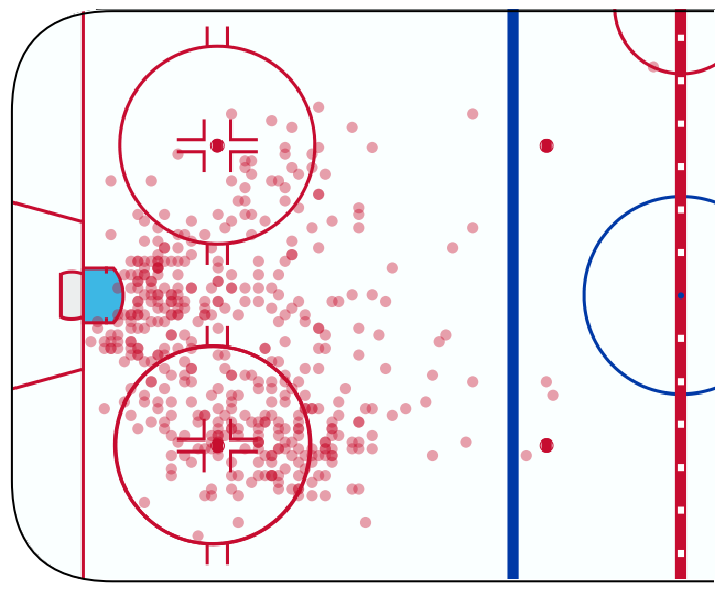

In [29]:
# load icerink image
icerink = cv2.imread('images/icerink.png', cv2.IMREAD_UNCHANGED)
icerink = cv2.cvtColor(icerink, cv2.COLOR_BGRA2RGBA)

# --------------------------------------------------------------- #
# annoying matplotlib stuff to properly plot the rink
plt.rcParams['figure.figsize'] = 12, 8
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0, 0, 1, 1])
ax.set_axis_off()
fig.add_axes(ax)

# for centering the origin at center ice
extent = [-100, 100, -42.5, 42.5]
# drawing black line around the edge
bb = mtransforms.Bbox([[-99.7, -42.675], [99.65, 42.25]])
p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                         abs(bb.width), abs(bb.height),
                         boxstyle="round, pad=0.1, rounding_size=15",
                         fill=False, ec='black', lw=2)
ax.add_patch(p_fancy)
ax.set_xlim(-100.5, 5)
ax.set_ylim(-43, 43)
# --------------------------------------------------------------- #

# put the rink on the plot
plt.imshow(icerink, extent=extent)

# plot goal data
plt.scatter(coords[:, 0], coords[:, 1], c='#C8102E', s=125, alpha=0.4, edgecolor='none')

# plt.savefig('OV700.png', transparent=True, dpi=300)
plt.show()

<IPython.core.display.Javascript object>


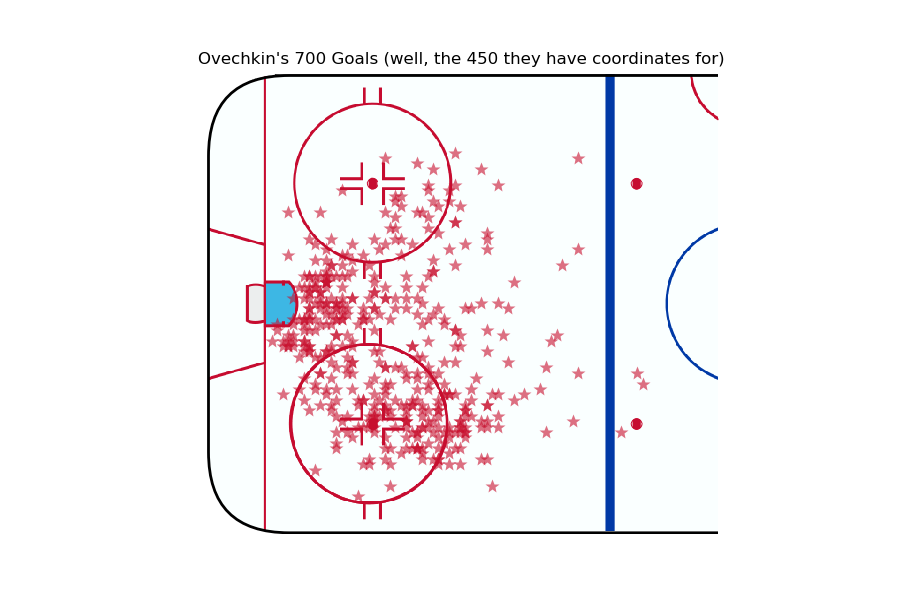

In [89]:
# annoying matplotlib stuff to properly plot the rink
plt.rcParams['figure.figsize'] = 9, 6
# fig = plt.figure(frameon=False)
# fig = plt.figure()
# ax = plt.Axes(fig, [0, 0, 1, 1])
# ax.set_axis_off()
# fig.add_axes(ax)

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_axis_off()

# for centering the origin at center ice
extent = [-100, 100, -42.5, 42.5]
# drawing black line around the edge
bb = mtransforms.Bbox([[-99.7, -42.675], [99.65, 42.25]])
p_fancy = FancyBboxPatch((bb.xmin, bb.ymin),
                         abs(bb.width), abs(bb.height),
                         boxstyle="round, pad=0.1, rounding_size=15",
                         fill=False, ec='black', lw=2)
ax.add_patch(p_fancy)
ax.set_xlim(-100.5, -5)
ax.set_ylim(-43, 43)
plt.imshow(icerink, extent=extent)

plt.title("Ovechkin's 700 Goals (well, the 450 they have coordinates for)")

goals, = plt.plot([], [], color='#C8102E', ls='', marker='*', ms=10, alpha=0.6, mec='none')

def update(i):
    goals.set_data(coords[:i, 0], coords[:i, 1])
    return goals

goal_ani = animation.FuncAnimation(fig, update, frames=range(470), interval=25)
goal_ani.save('OV700.mp4')
# plt.show()